In [1]:
# STEP 1: Imports & Helper functions
import numpy as np, time, matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Optional libs
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    HAS_TF = True
except Exception:
    HAS_TF = False

# Helper function
def show_images(X_imgs, y_true, y_pred=None, n=5, title="Samples"):
    n = min(n, len(X_imgs))
    plt.figure(figsize=(2.2*n, 2.6))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X_imgs[i], cmap="gray")
        if y_pred is None:
            t = f"Actual: {y_true[i]}"
        else:
            t = f"Actual: {y_true[i]}\nPrediction: {y_pred[i]}"
        plt.title(t, fontsize=8)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

MODEL_REGISTRY, TEST_CACHE = {}, {}


X:\ProgramData\anaconda3\envs\UL_YOLO\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


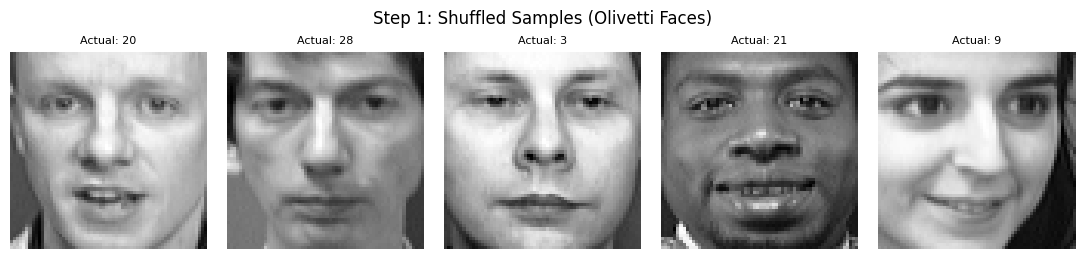

In [2]:
# STEP 2: Load data and display samples
data = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = data.images, data.target

show_images(X, y, n=5, title="Step 1: Shuffled Samples (Olivetti Faces)")


In [3]:
# STEP 3: Prepare data for ML and CNN
X_train_img, X_test_img, y_train, y_test = train_test_split(
    X, y, test_size=0.6, stratify=y, random_state=42
)

# Flatten + scale for classical ML
X_train_flat = X_train_img.reshape(len(X_train_img), -1)
X_test_flat  = X_test_img.reshape(len(X_test_img), -1)
scaler = StandardScaler().fit(X_train_flat)
Xs_train, Xs_test = scaler.transform(X_train_flat), scaler.transform(X_test_flat)

# For CNN
X_train_cnn, X_test_cnn = X_train_img[..., np.newaxis], X_test_img[..., np.newaxis]

TEST_CACHE["flat"] = (X_test_img, Xs_test, y_test)
TEST_CACHE["cnn"]  = (X_test_img, X_test_cnn, y_test)


In [4]:
# STEP 4.0: Model creationg prepartion

def train_and_report(name, model, Xtr, ytr, Xte, yte, kind="flat", scaler_obj=None, sample_show=5):
    t0 = time.time()
    model.fit(Xtr, ytr)
    train_time = time.time() - t0

    y_tr_pred = model.predict(Xtr)
    y_te_pred = model.predict(Xte)
    tr_acc = accuracy_score(ytr, y_tr_pred)
    te_acc = accuracy_score(yte, y_te_pred)

    print(f"{name}: train_acc={tr_acc:.3f} | test_acc={te_acc:.3f} | time={train_time:.2f}s")
    show_images(TEST_CACHE[kind][0][:sample_show], yte[:sample_show], y_te_pred[:sample_show],
                title=f"{name} Predictions")
    MODEL_REGISTRY[name] = {"model": model, "scaler": scaler_obj, "kind": kind}

KNN: train_acc=0.887 | test_acc=0.742 | time=0.00s


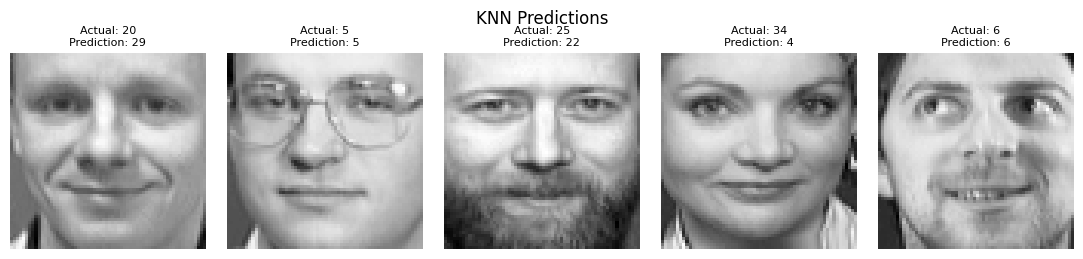

In [5]:
# STEP 4.1 – KNN
knn = KNeighborsClassifier(3)
train_and_report("KNN", knn, Xs_train, y_train, Xs_test, y_test, "flat", scaler)


Decision Tree: train_acc=0.700 | test_acc=0.408 | time=0.86s


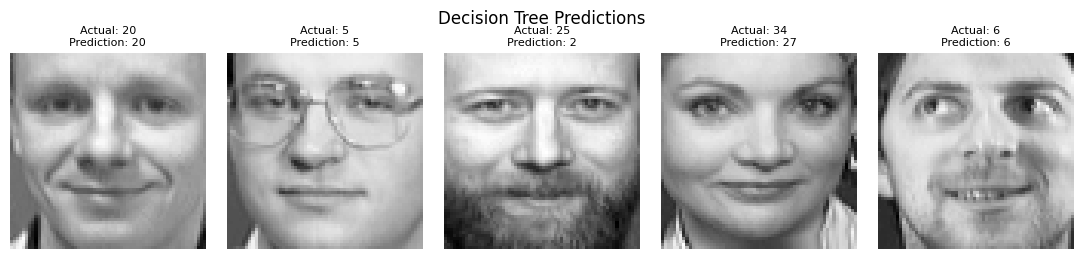

In [6]:
# STEP 4.2 – Decision Tree
dt = DecisionTreeClassifier(max_depth=25, random_state=42)
train_and_report("Decision Tree", dt, Xs_train, y_train, Xs_test, y_test, "flat", scaler)


Random Forest: train_acc=1.000 | test_acc=0.921 | time=0.26s


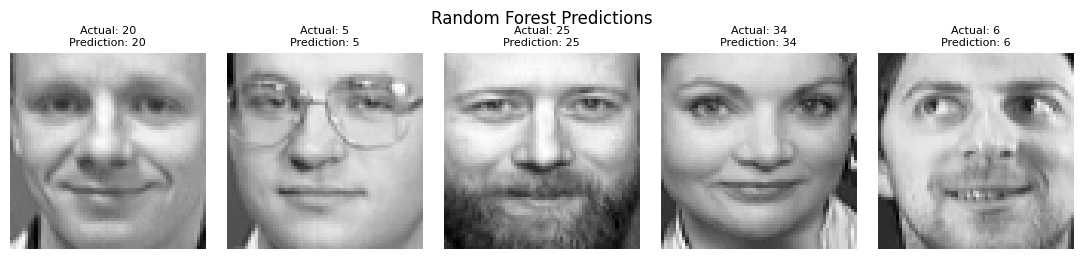

In [7]:
# STEP 4.3 – Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
train_and_report("Random Forest", rf, Xs_train, y_train, Xs_test, y_test, "flat", scaler)


MLP: train_acc=1.000 | test_acc=0.879 | time=0.81s


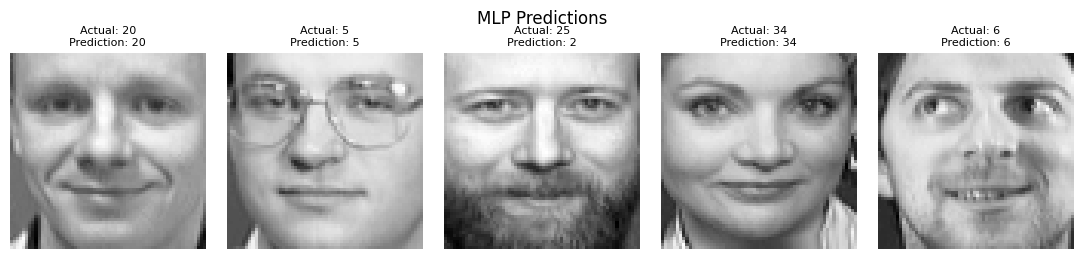

In [8]:
# STEP 4.4 – MLP
mlp = MLPClassifier(hidden_layer_sizes=(256,), max_iter=200, random_state=42)
train_and_report("MLP", mlp, Xs_train, y_train, Xs_test, y_test, "flat", scaler)


XGBoost: train_acc=1.000 | test_acc=0.692 | time=36.65s


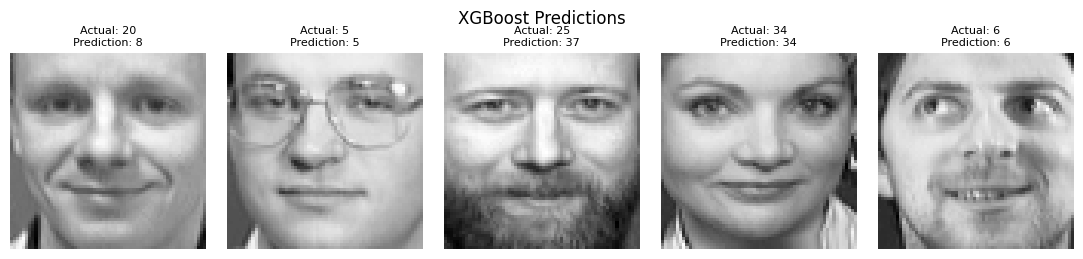

In [9]:
# STEP 4.5 – XGBoost
if HAS_XGB:
    xgb = XGBClassifier(max_depth=6, n_estimators=300, learning_rate=0.06, random_state=42)
    train_and_report("XGBoost", xgb, Xs_train, y_train, Xs_test, y_test, "flat", scaler)
else:
    print("XGBoost not installed; skipping.")


CNN: train_acc=0.075 | test_acc=0.058 | time=1.07s


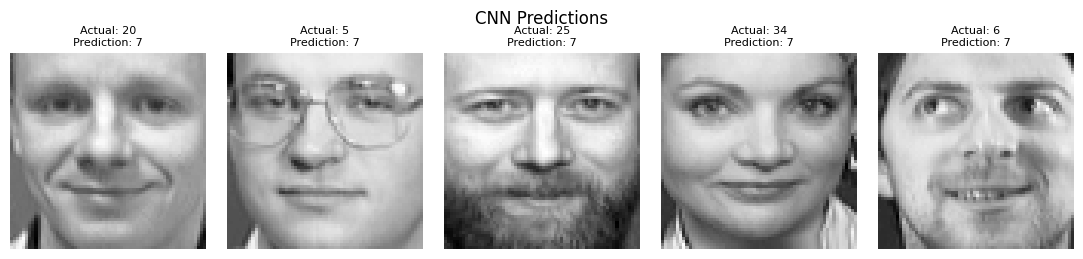

In [10]:
# STEP 4.6 – CNN
if HAS_TF:
    cnn = models.Sequential([
        layers.Input(shape=(64,64,1)),
        layers.Conv2D(16,3,padding="same",activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32,3,padding="same",activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64,activation="relu"),
        layers.Dense(40,activation="softmax")
    ])
    cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    t0 = time.time()
    cnn.fit(X_train_cnn, y_train, epochs=8, batch_size=64, verbose=0)
    train_time = time.time()-t0

    tr_acc = cnn.evaluate(X_train_cnn, y_train, verbose=0)[1]
    te_acc = cnn.evaluate(X_test_cnn, y_test, verbose=0)[1]
    print(f"CNN: train_acc={tr_acc:.3f} | test_acc={te_acc:.3f} | time={train_time:.2f}s")

    y_pred_cnn = np.argmax(cnn.predict(X_test_cnn, verbose=0), axis=1)
    show_images(X_test_img[:5], y_test[:5], y_pred_cnn[:5], title="CNN Predictions")

    MODEL_REGISTRY["CNN"] = {"model": cnn, "scaler": None, "kind": "cnn"}
else:
    print("TensorFlow not installed; skipping CNN.")


In [ ]:
# STEP 5: Simple UI (choose model & number of images)
from ipywidgets import interact, Dropdown, IntSlider

def predict_with_model(model_name, n_images):
    entry = MODEL_REGISTRY[model_name]
    kind = entry["kind"]
    Ximg, Xte, yte = TEST_CACHE[kind]

    if model_name == "CNN":
        y_pred = np.argmax(entry["model"].predict(Xte[:n_images], verbose=0), axis=1)
    else:
        y_pred = entry["model"].predict(Xte[:n_images])
    show_images(Ximg[:n_images], yte[:n_images], y_pred[:n_images],
                title=f"{model_name} Predictions")

interact(
    predict_with_model,
    model_name=Dropdown(options=list(MODEL_REGISTRY.keys()), description="Model"),
    n_images=IntSlider(min=1, max=20, step=1, value=5, description="#Images")
)
